In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import ast

from multiprocessing import Pool

In [2]:
import tensorflow as tf
from tensorflow import keras


from tensorflow.keras.layers import Dense, Input, LSTM, GRU, Flatten, Reshape, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint 
from tensorflow.keras.utils import plot_model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.losses import MeanSquaredError, CosineSimilarity

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Lectura y preprocesado de los datos

In [4]:
Y = np.load('../../Data/Y_10.npy')
X = np.load('../../Data/X_10.npy')

print('X shape:')
print(X.shape)

print('Y shape:')
print(Y.shape)

X shape:
(1000000, 10, 64)
Y shape:
(1000000, 64)


In [5]:
val_size = int(X.shape[0]*0.1) #10%

X_train = X[:-val_size,:,:]
X_val = X[-val_size:,:,:]

Y_train = Y[:-val_size,:]
Y_val = Y[-val_size:,:]

print('X train:')
print(X_train.shape)
print('Y train:')
print(Y_train.shape)

print('X val:')
print(X_val.shape)
print('Y val:')
print(Y_val.shape)

X train:
(900000, 10, 64)
Y train:
(900000, 64)
X val:
(100000, 10, 64)
Y val:
(100000, 64)


# BiLSTM

In [6]:
num_units = 16

In [7]:
input_shape = (X_train.shape[1],X_train.shape[2])

input_layer = Input(shape= input_shape, name='Inputs')

model_layers = Bidirectional(LSTM(units = num_units, return_sequences=True))(input_layer)
#model_layers = Bidirectional(LSTM(units = num_units, return_sequences=True))(model_layers)
model_layers = Bidirectional(LSTM(units = num_units))(model_layers)


model_layers = Dense(Y_train.shape[1], activation='sigmoid', name='Output')(model_layers)

model_bilstm = Model(input_layer, model_layers, name ='model_bilstm')
model_bilstm.summary()

Model: "model_bilstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Inputs (InputLayer)          [(None, 10, 64)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 32)            10368     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                6272      
_________________________________________________________________
Output (Dense)               (None, 64)                2112      
Total params: 18,752
Trainable params: 18,752
Non-trainable params: 0
_________________________________________________________________


## Entrenamiento

In [8]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", patience=2)

In [9]:
optimizer = Adam(learning_rate=1e-3)
loss_fn = CosineSimilarity()
model_bilstm.compile(optimizer= optimizer, loss = loss_fn)

In [10]:
epochs = 5
batch_size = 32

history = model_bilstm.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs = epochs, batch_size=batch_size, callbacks=[callback], verbose=1)

Train on 900000 samples, validate on 100000 samples
Epoch 1/5
900000/900000 [==============================] - 122s 136us/sample - loss: -0.8586 - val_loss: -0.8626
Epoch 2/5
900000/900000 [==============================] - 123s 137us/sample - loss: -0.8627 - val_loss: -0.8636
Epoch 3/5
900000/900000 [==============================] - 123s 137us/sample - loss: -0.8635 - val_loss: -0.8644
Epoch 4/5
900000/900000 [==============================] - 121s 134us/sample - loss: -0.8639 - val_loss: -0.8645
Epoch 5/5
900000/900000 [==============================] - 120s 133us/sample - loss: -0.8642 - val_loss: -0.8648


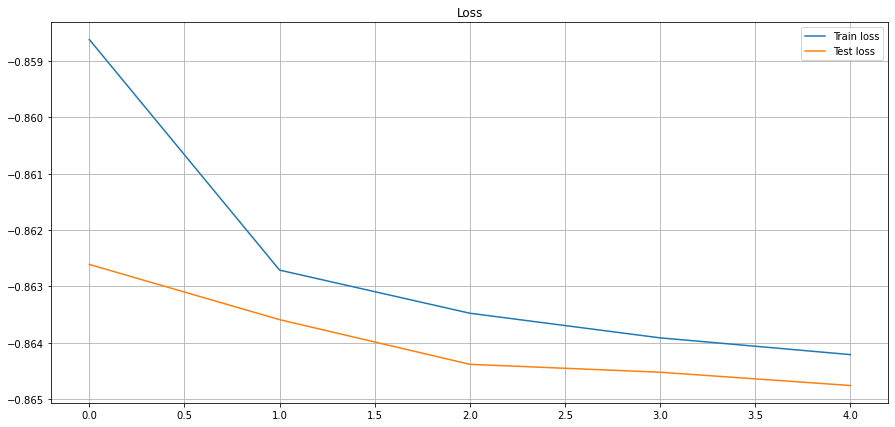

In [11]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'],label='Train loss')
plt.plot(history.history['val_loss'],label='Test loss')
plt.title('Loss')
plt.legend()
plt.grid()
plt.show()

In [12]:
model_bilstm.save('biLSTM_v1')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: biLSTM_v1\assets


In [13]:
predicted_latent_items = model_bilstm(np.float32(X_val[0:1,:,:])).numpy()

for i in tqdm(range(1, X_val.shape[0])):
    
    predicted_item = model_bilstm(np.float32(X_val[i:i+1,:,:])).numpy() 
    
    predicted_latent_items = np.vstack((predicted_latent_items,predicted_item))


100%|████████████████████████████████████████████████████████████████████████████| 99999/99999 [18:41<00:00, 89.20it/s]


In [14]:
predicted_latent_items.shape

(100000, 64)

In [16]:
predicted_latent_items

array([[0.03001219, 0.02285046, 0.11123247, ..., 0.2174379 , 0.13556367,
        0.53428376],
       [0.04480297, 0.02056499, 0.65720874, ..., 0.15079445, 0.18790424,
        0.8781772 ],
       [0.09069615, 0.01689952, 0.46793276, ..., 0.04381172, 0.4438121 ,
        0.5558452 ],
       ...,
       [0.09203291, 0.11657979, 0.01752353, ..., 0.04443192, 0.43023375,
        0.26202703],
       [0.12116665, 0.12592562, 0.02007756, ..., 0.04895597, 0.23932163,
        0.30425912],
       [0.04905581, 0.03472475, 0.5129408 , ..., 0.41745433, 0.43666276,
        0.6858212 ]], dtype=float32)

In [15]:
np.save('predicted_val_biLSTM_latent_items', predicted_latent_items)